In [1]:
from hw3 import *

From HW3 inherited the weekly portfolio weights

In [2]:
import pandas as pd
import yfinance as yf

# Functions' definitions

In [3]:
def cal_beta(stk_ror_array,bmk_ror_array)->float:
    X_array = sm.add_constant((bmk_ror_array - ror_10_treasure_float).reshape(-1, 1))
    y_array = (stk_ror_array - ror_10_treasure_float).reshape(-1, 1)
    model = sm.OLS(y_array, X_array)
    result = model.fit()
    beta_float = result.params[1]
    return beta_float

def IR(pfl_r_array:np.array,bmk_r_array:np.array)->float:
    std_float = np.std(pfl_r_array - bmk_r_array)
    IR_float = np.mean(pfl_r_array-bmk_r_array)/std_float
    return IR_float

def sharp(ror_d_array):
    ror_d_array = ror_d_array.reshape(-1,1)
    ror_y_float = np.exp(np.log(1+ror_d_array).sum() / (len(ror_d_array)/252))-1
    std_y_float = np.std(ror_d_array)*np.sqrt(252)
    return (ror_y_float-0.03319)/std_y_float

def max_drawdown(pfl_ret_df):
    loc_end_int = np.argmax((np.maximum.accumulate(pfl_ret_df)-pfl_ret_df)/np.maximum.accumulate(pfl_ret_df))
    loc_beg_int = np.argmax(pfl_ret_df.iloc[:loc_end_int,0])
    max_drawdown_float = pfl_ret_df.iloc[loc_beg_int,0]-pfl_ret_df.iloc[loc_end_int,0]
    return max_drawdown_float

def VaR_std_m(confidence_level_float,asset_val_df,period_int = 1):
    daily_ror_df = asset_val_df/asset_val_df.shift(1)-1
    daily_ror_df.fillna(0,inplace=True)
    std_float = daily_ror_df.std(axis=0)
    std_y_float = std_float*np.sqrt(252)
    z_quantile_float = norm.ppf(confidence_level_float,loc = 0, scale = 1)
    var_float = (std_y_float*z_quantile_float*np.sqrt(period_int/252))*asset_val_df.iloc[0,0]
    return var_float

def VaR_series(confidence_level_float,daily_ret_df,period_int=1):
    confidence_level_float *=100
    daily_ret_df = daily_ret_df
    Var_float = np.percentile(daily_ret_df.values,100-confidence_level_float,interpolation='midpoint')*period_int
    return Var_float

def VaR(confidence_level_float,daily_ret_df,period_int = 1,method_str='series'):
    if method_str=='series':
        return VaR_series(confidence_level_float,daily_ret_df,period_int)
    elif method_str=='std':
        return VaR_std_m(confidence_level_float, daily_ret_df,period_int)

def ETL(confidence_level_float,daily_ret_df,period_int = 1,method_str='series'):
    VaR_float = VaR(confidence_level_float,daily_ret_df,period_int,method_str)
    etl_ret_df = daily_ret_df[daily_ret_df<=VaR_float]
    etl_float = etl_ret_df.mean().values[0]
    return etl_float

In [4]:
# Download SPY data from Yahoo Finance
try:
    spy_close_df = pd.read_csv(r'E:\study\22fall\hf\data\hw4\spy_close.csv',index_col=0)
except:
    data = yf.download(tickers='SPY',start = '2021-08-09',end = '2022-09-30')
    spy_close_df = data.iloc[:,-2]
    spy_close_df.to_csv(r'E:\study\22fall\hf\data\hw4\spy_close.csv')

spy_ror_df = spy_close_df/spy_close_df.shift(1)-1
spy_ror_df.index = pd.to_datetime(spy_ror_df.index)
spy_ror_df.columns = ['SPY']

# (A)
# Calculation of Statistic

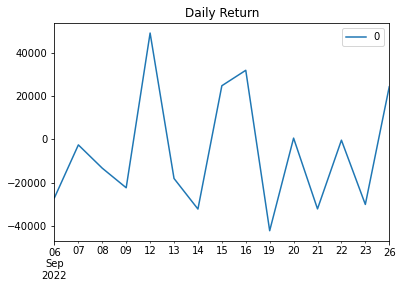

IR:0.0786150186187113,
Correlation Coefficient: 0.06389977933188826,
Beta: 0.07126328422663239,
Sharp: -2.6410038984703363


In [5]:
asset_val_df = pos.daily_asset_val(dat_df,True)
pfl_ret_df = asset_val_df-asset_val_df.shift(1)
pfl_ret_df.dropna(axis=0,inplace=True)

#daily return plotting
pfl_ret_df.plot()
plt.title('Daily Return')
plt.show()

pfl_ror_df = asset_val_df/asset_val_df.shift(1)-1
pfl_ror_df.dropna(axis=0,inplace=True)
data_df = pd.merge(spy_ror_df,pfl_ror_df,left_index=True,right_index=True).fillna(0)
#statistics
IR_series = data_df.iloc[:,1:].apply(axis=0,func = IR,args = (data_df.iloc[:,0],))
corr_series = data_df.iloc[:,1:].corrwith(data_df.iloc[:,0],axis=0)
beta_float = cal_beta(data_df.iloc[:,0].values,data_df.iloc[:,1].values)
sharp_float = sharp(data_df.iloc[:,1].values)
print(f'IR:{IR_series[0]},\nCorrelation Coefficient: {corr_series[0]},\nBeta: {beta_float},\nSharp: {sharp_float}')

### Assesement:
1. The strategy's performance is far from good from IR's perspective, which shows that it is too risky for its return.
2. Its correlation with S&P500 is very low, which is welcomed. Market ${\beta}$ tells the same story.
Under current circumstances,where S&P500 has dropped 8%
during backtest period and there is no sign for recovery, it is better for a strategy to be less correlated to the market.
3. The Sharp ratio of the strategy is also very terrible even with negative sign, showing that weekly momentum is not
effective recently.


# (B) VaR and ETL

In [6]:
VaR_float = VaR(0.75,pfl_ret_df,method_str='series')
ETL_float = ETL(0.75,pfl_ret_df,method_str='series')
max_drawdown_float = max_drawdown(asset_val_df)
print(f'VaR (historical method): {VaR_float},\n ETL (historical method): {ETL_float},\n Max Drawdown of Return: {max_drawdown_float}')

VaR (historical method): -28544.066656078678,
 ETL (historical method): -34170.0520240303,
 Max Drawdown of Return: 114218.61009649513


# (C) Operations
### Difficulties in backtest:
1.The biggest challenge is about short position. Short sales can use leverage, which will leads to short sales proceeds and
 its interests, margin ratio and possibility to maintain margin ration by adding more money to margin account. Also, the
 assets' value of short position is not as straightforward as long position.
 2.transaction fee/rate settings are very tricky and maybe different from the settings in backtest.
 Actual trading results may be completely different from that of backtest.
### Operational risk:
1. Employing short sales may lead to actual margin ratio lower than maintenance margin and a margin call. Then, we have to
 put up more money or change short position in time to avoid additional possible loss or restrictions on trading.
2. Be careful of brokerage fee and stock loan fee, which can be so expensive that all profits generated may be wiped out
  and even end up in a loss. Considering stock loan fee, short position should be altered to lower transaction cost.
3. Beware of liquidity of short sales stocks in case of being recalled.
4. up-tick rule should be kept in mind when constructing short position.
5. Some misunderstandings of PNL may arise from short position.

# (D) Future
1. The strategy is very basic and known to all. However, it still works during some period. Therefore, we should not
abandon the strategy at all but try to find correct timing for employing this strategy.
2. Despite its poor return and volatility, its low correlation with market is preferable.
3. Being one of the most basic signal, though extremely simple, means its capacity is relatively high when it is the right time.
4. Considering a momentum made up by longer periods' return, like 120,250 days, which maybe more reliable.

# (E) Environment
1. Under current circumstances where there seems to be no recovery in the short term, the optimal strategy first is to
get ourselves rid of markets' effects. Specifically, it means an ideal strategy should have zero or low correlation with market.
2. Momentum is the most basic and famous signal with well explained economic intuitions in all markets with great potential even today.
With careful timing and regime selection, it still has chances to shine.